## Figure 5 for Acoustic Features paper.  Performance of encoder and tuning curves

The data used here is generated by running the acousticEncoder models on all the pre-processed data as explained in the figure5.ipnb document.  The acousticEncoder runs all the encoder models of interest and is also a wrapper to run through all the data set.  The code is found in testCode/acousticEncoder.py (https://github.com/ftheunissen/testCode) 
An aggregate pandas data frame that has the results of all these encoders is then generated by
testCode/acousticEncoderAgg.py.
This code starts by reading this aggregate results data frame.

In [8]:
# Dependencies
import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

# Location of pandas data frame.  Change if you stored it somewhere else.
agg_file = '/Users/frederictheunissen/Documents/Data/mschachter/aggregate/encoder_all.pkl'


In [2]:
# More Global Parameters
exp_names = ['YelBlu6903F', 'GreBlu9508M', 'WhiWhi4522M' ]   # The 3 birds that are part of this data set
decomps = ['spike_rate', 'full_psds']   # The two types of neural representations: the spike rate and the power spectrum decomposition of LFPs

In [3]:
# Read the summary data file
resultsPD = pd.read_pickle(agg_file)

In [4]:
resultsPD

,W,alpha,b,features,group,name,neural feat,predict,r2,r2_std,experiment,site,decomp
0,"[-0.00633447747250839, 0.0009748100639300066, ...",8.685114,-0.076329,"[b'maxAmp', b'stdtime', b'loud', b'meanspect',...",[All],Full,0,"[0.0997924720033009, 0.09179340833664175, 0.18...",7.754766e-03,7.916633e-03,WhiWhi4522M,Site2_Call2_L,spike_rate
1,"[-0.0052064930135752256, 0.0008244797599543173...",0.625055,0.149087,"[b'maxAmp', b'stdtime', b'loud', b'meanspect',...",[All],Full,1,"[0.37738279307382316, -0.049875222951131476, -...",2.827130e-02,4.254014e-02,WhiWhi4522M,Site2_Call2_L,spike_rate
2,"[-1.20504013827781e-07, 2.4434889084032628e-08...",1000000.000000,-0.015365,"[b'maxAmp', b'stdtime', b'loud', b'meanspect',...",[All],Full,2,"[-0.015363040846590239, -0.015362869424259382,...",-9.840499e-08,3.219802e-07,WhiWhi4522M,Site2_Call2_L,spike_rate
3,"[-0.0031837231725209327, 0.0005375826187942629...",26.826958,-0.055702,"[b'maxAmp', b'stdtime', b'loud', b'meanspect',...",[All],Full,3,"[0.004136489043219102, 0.01427963274674568, 0....",2.342159e-03,3.896993e-03,WhiWhi4522M,Site2_Call2_L,spike_rate
4,"[3.214333565946781e-08, -7.032418923110923e-09...",1000000.000000,0.007862,"[b'maxAmp', b'stdtime', b'loud', b'meanspect',...",[All],Full,4,"[0.00786182559984384, 0.007861906249447709, 0....",-2.563794e-08,6.334430e-08,WhiWhi4522M,Site2_Call2_L,spike_rate
5,"[-7.433115956459988e-08, 1.4654175294501057e-0...",1000000.000000,-0.010894,"[b'maxAmp', b'stdtime', b'loud', b'meanspect',...",[All],Full,5,"[-0.010893421983436229, -0.010892729118763742,...",-3.767428e-08,2.318846e-07,WhiWhi4522M,Site2_Call2_L,spike_rate
6,"[-0.0033467700715376853, 0.000866543858731224,...",2.811769,-0.055366,"[b'maxAmp', b'stdtime', b'loud', b'meanspect',...",[All],Full,6,"[0.10790132417226198, -0.013816990569991514, 0...",4.275185e-02,2.021497e-02,WhiWhi4522M,Site2_Call2_L,spike_rate
7,"[-1.208249176414905e-05, -1.5238638430255503e-...",2.811769,-0.006951,"[b'meanspect', b'stdspect', b'skewspect', b'ku...",0,Nested,6,"[-0.09001688587061304, -0.011504272777184753, ...",4.099815e-02,2.021488e-02,WhiWhi4522M,Site2_Call2_L,spike_rate
8,"[-0.002995694261636327, 0.0008071054086848917,...",1.930698,-0.148464,"[b'maxAmp', b'stdtime', b'loud', b'stdspect', ...",1,Nested,6,"[0.07164750640302445, -0.07291751283907535, -0...",3.693394e-02,2.222862e-02,WhiWhi4522M,Site2_Call2_L,spike_rate
9,"[-0.003315165902350455, 0.0008539975126299764,...",2.811769,-0.091882,"[b'maxAmp', b'stdtime', b'loud', b'meanspect',...",2,Nested,6,"[0.11495854295408295, 0.0005357885969068665, 0...",4.412353e-02,2.074333e-02,WhiWhi4522M,Site2_Call2_L,spike_rate


In [12]:
# Select r2 for full model for each site and decomposition to make hitograms and bar plot

mfullSpike = resultsPD.loc[(resultsPD['name'] =='Full') & (resultsPD['decomp'] == 'spike_rate')] 
mfullLFPLow = resultsPD.loc[(resultsPD['name'] =='Full') & (resultsPD['decomp'] == 'full_psds') & (resultsPD['neural feat'] < 16)] 
mfullLFPMed = resultsPD.loc[(resultsPD['name'] =='Full') & (resultsPD['decomp'] == 'full_psds') & (resultsPD['neural feat'] < 32) & (resultsPD['neural feat'] >= 16)]
mfullLFPHigh = resultsPD.loc[(resultsPD['name'] =='Full') & (resultsPD['decomp'] == 'full_psds') & (resultsPD['neural feat'] >= 32)] 

### Make plot of full encoder model R2

([<matplotlib.axis.XTick at 0x11ab5c0b8>,
 <a list of 4 Text xticklabel objects>)

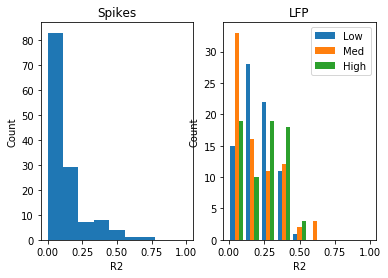

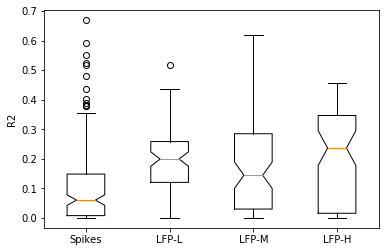

In [37]:
plt.figure()

# Histogram for spikes
plt.subplot(1,2,1)
plt.hist(mfullSpike['r2'], bins = np.linspace(0.0, 1.0, 10))
plt.xlabel('R2')
plt.ylabel('Count')
plt.title('Spikes')

# Histogram for LFS
plt.subplot(1,2,2)
plt.hist([mfullLFPLow['r2'].dropna(), mfullLFPMed['r2'].dropna(), mfullLFPHigh['r2'].dropna()],
         bins = np.linspace(0.0, 1.0, 10),  histtype = 'bar', stacked = False)
plt.xlabel('R2')
plt.ylabel('Count')
plt.title('LFP')
plt.legend(['Low', 'Med', 'High'])

# Boxplot
plt.figure()
plt.boxplot([mfullSpike['r2'].dropna(), mfullLFPLow['r2'].dropna(), mfullLFPMed['r2'].dropna(), mfullLFPHigh['r2'].dropna()], 1)
plt.ylabel('R2')
plt.xticks([1,2,3,4], ['Spikes', 'LFP-L', 'LFP-M', 'LFP-H'])

64 Significant Single Units


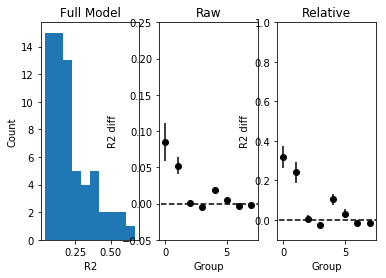

In [57]:
# Make Plots of Partial R2

# First for spikes
mfullSpikeSig = mfullSpike.loc[(mfullSpike['r2'] >= 2.0*mfullSpike['r2_std'])]
# Find the number of units
n_units = len(mfullSpikeSig.index)
print('%d Significant Single Units' % n_units)

# Feature groups.  These group of features are defined in acousticEncoder.py

feature_groups = ['Loud', 'Mean S', 'BW S', 'Shape S', 'Shape T', 'Sal', 'Fund', 'CV Fund']
n_features = len(feature_groups)

r2_full_all = np.full(n_units, np.nan)
r2_diff_all = np.full((n_units, n_features), np.nan)
r2_reldiff_all = np.full((n_units, n_features), np.nan)
                         
for i_n in range(n_units):
    r2_full_all[i_n] = mfullSpikeSig['r2'].iloc[i_n]
    bird = mfullSpikeSig['experiment'].iloc[i_n] 
    site = mfullSpikeSig['site'].iloc[i_n]   
    neural_feat = mfullSpikeSig['neural feat'].iloc[i_n] 
    for i_f in range(n_features):
        # Find the correct record
        mNestedSpike = resultsPD.loc[(resultsPD['name'] =='Nested') & 
                                     (resultsPD['decomp'] == 'spike_rate') &
                                     (resultsPD['group'] == i_f) &
                                     (resultsPD['experiment'] == bird) &
                                     (resultsPD['site'] == site) &
                                     (resultsPD['neural feat'] == neural_feat)] 
        if len(mNestedSpike.index) != 1:
            print('Error: too many or two few entries')
        else:
            r2_diff_all[i_n, i_f] = r2_full_all[i_n] - mNestedSpike['r2'].iloc[0]
            r2_reldiff_all[i_n, i_f] = r2_diff_all[i_n, i_f]/r2_full_all[i_n]


plt.figure()
plt.subplot(1,3,1)
plt.hist(r2_full_all[np.logical_not(np.isnan(r2_full_all))])
plt.xlabel('R2')
plt.ylabel('Count')
plt.title('Full Model')
    
plt.subplot(1,3,2)
plt.errorbar(range(len(feature_groups)), np.nanmean(r2_diff_all, axis=0), yerr = 2.0*(np.nanstd(r2_diff_all, axis=0, ddof=1))/np.sqrt(n_units) , fmt='ko')
plt.axis([-0.5, 7.5, -0.05, 0.25]) 
plt.hlines(0, -1, 8, colors='k', linestyles='dashed')
plt.xlabel('Group')
plt.ylabel('R2 diff')
plt.title('Raw')
    
plt.subplot(1,3,3)
plt.errorbar(range(len(feature_groups)), np.nanmean(r2_reldiff_all, axis=0), yerr = 2.0*(np.nanstd(r2_reldiff_all, axis=0, ddof=1))/np.sqrt(n_units) , fmt='ko')
plt.axis([-0.5, 7.5, -0.1, 1.0]) 
plt.hlines(0, -1, 8, colors='k', linestyles='dashed')
plt.xlabel('Group')
plt.ylabel('R2 diff')
plt.title('Relative')
plt.show()


In [55]:
resultsPD['neural feat']



0        0
1        1
2        2
3        3
4        4
5        5
6        6
7        6
8        6
9        6
10       6
11       6
12       6
13       6
14       6
15       6
16       7
17       8
18       9
19      10
20      11
21      12
22      13
23      14
24      15
25      16
26      17
27      17
28      17
29      17
        ..
3437    17
3438    18
3439    19
3440    20
3441    21
3442    22
3443    23
3444    25
3445    26
3446    27
3447    28
3448    29
3449    30
3450    31
3451    32
3452    33
3453    34
3454    35
3455    36
3456    37
3457    38
3458    39
3459    40
3460    41
3461    42
3462    43
3463    44
3464    45
3465    46
3466    47
Name: neural feat, Length: 3467, dtype: int64

In [48]:
mfullSpikeSig

,W,alpha,b,features,group,name,neural feat,predict,r2,r2_std,experiment,site,decomp
6,"[-0.0033467700715376853, 0.000866543858731224,...",2.811769,-0.055366,"[b'maxAmp', b'stdtime', b'loud', b'meanspect',...",[All],Full,6,"[0.10790132417226198, -0.013816990569991514, 0...",0.042752,0.020215,WhiWhi4522M,Site2_Call2_L,spike_rate
26,"[-0.04484714651635479, 0.001757358617780705, 0...",0.138950,0.277463,"[b'maxAmp', b'stdtime', b'loud', b'meanspect',...",[All],Full,17,"[0.048690323698611204, -0.26709939591107684, -...",0.148312,0.070722,WhiWhi4522M,Site2_Call2_L,spike_rate
38,"[0.05762964024143919, -0.0136169915997556, 0.0...",0.202359,1.901571,"[b'maxAmp', b'stdtime', b'loud', b'meanspect',...",[All],Full,21,"[-0.8413958889356166, -0.30631502986660664, -0...",0.290711,0.045344,WhiWhi4522M,Site2_Call2_L,spike_rate
48,"[0.06338009053075414, -0.014453207235590739, 0...",0.294705,2.116792,"[b'maxAmp', b'stdtime', b'loud', b'meanspect',...",[All],Full,22,"[-0.4472605030114738, -0.33671216093605505, -1...",0.354470,0.068151,WhiWhi4522M,Site2_Call2_L,spike_rate
60,"[-0.013847394096129572, -0.0033691417780651956...",0.294705,0.448027,"[b'maxAmp', b'stdtime', b'loud', b'meanspect',...",[All],Full,25,"[-0.223370394557119, -0.4234169774535232, -0.9...",0.103441,0.047464,WhiWhi4522M,Site2_Call2_L,spike_rate
97,"[-0.050348829294822074, 0.00661197294793178, -...",0.625055,0.578084,"[b'maxAmp', b'stdtime', b'loud', b'meanspect',...",[All],Full,0,"[0.5600975246815659, 0.48367149227285156, 0.41...",0.083828,0.039344,WhiWhi4522M,Site4_Call1_L,spike_rate
108,"[-0.0028502147173831505, -0.002004990524415727...",1.930698,0.651404,"[b'maxAmp', b'stdtime', b'loud', b'meanspect',...",[All],Full,3,"[0.19286213640109295, 0.33664139828785283, 0.4...",0.105404,0.043415,WhiWhi4522M,Site4_Call1_L,spike_rate
118,"[-0.012847964000319137, 9.427941831536276e-05,...",1.325711,0.545275,"[b'maxAmp', b'stdtime', b'loud', b'meanspect',...",[All],Full,4,"[0.10953385872034677, 0.2766956690435558, 0.26...",0.085211,0.031249,WhiWhi4522M,Site4_Call1_L,spike_rate
148,"[0.016993004453231993, -0.0032944417991418768,...",2.811769,0.188512,"[b'maxAmp', b'stdtime', b'loud', b'meanspect',...",[All],Full,25,"[0.1887254577059237, -0.32051112441356755, -0....",0.062833,0.029111,WhiWhi4522M,Site4_Call1_L,spike_rate
157,"[0.017843231588864538, -0.0034595302499554888,...",2.811769,0.243486,"[b'maxAmp', b'stdtime', b'loud', b'meanspect',...",[All],Full,26,"[0.08394836617907381, -0.37139335553687264, -0...",0.075586,0.033868,WhiWhi4522M,Site4_Call1_L,spike_rate
